In [1]:
%load_ext autoreload
%autoreload 2

# from jax import config
# config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import numpy as onp
import time
from tqdm import tqdm
from encoding_information.bsccm_utils import *
from encoding_information.plot_utils import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import StationaryGaussianProcess
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from matplotlib.colors import LinearSegmentedColormap
from jax import jit
import jax.numpy as np


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-12-15 14:34:18.812577: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 14:34:19.650960: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


# Dont forget to enable 64 bit when optimizing

## Show stationary process approximation

In [3]:
N_images = 2000
patch_size = 30
edge_crop = 24

photons_per_pixel = 150
# channel = 'DPC_Right'
channel = 'LED119'

images = load_bsccm_images(bsccm, channel, num_images=N_images, convert_units_to_photons=True, edge_crop=edge_crop)
images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))

N_patches = 5000
patches = extract_patches(images, patch_size=patch_size, num_patches=N_patches)

In [5]:
sample_size = patch_size    
num_images_to_show = 5
eigenvalue_floor = 1e-1

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor, verbose=True)
gp.fit(patches, eigenvalue_floor=eigenvalue_floor, verbose=True)
# cov_mat = gp.get_cov_mat()
# samples = gp.generate_samples(num_images_to_show, sample_size)

trying to make doubly toeplitz and positive definite
made positive definite, smallest ev: 48.814713
Initial validation NLL: 4.09


Epoch 1: 100%|██████████| 1/1 [00:14<00:00, 14.26s/it]


Epoch 1: validation NLL: 4.09


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 20.32it/s]


Epoch 2: validation NLL: 4.09


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 21.67it/s]


Epoch 3: validation NLL: 4.09


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


Epoch 4: validation NLL: 4.09


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 21.65it/s]


Epoch 5: validation NLL: 4.09


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch 6: validation NLL: 4.09


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


Epoch 7: validation NLL: 4.09


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 21.12it/s]


Epoch 8: validation NLL: 4.09


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 21.00it/s]


Epoch 9: validation NLL: 4.09


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 21.56it/s]


Epoch 10: validation NLL: 4.09


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 21.67it/s]


Epoch 11: validation NLL: 4.09


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 21.34it/s]


Epoch 12: validation NLL: 4.09


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 21.66it/s]


Epoch 13: validation NLL: 4.09


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 21.46it/s]


KeyboardInterrupt: 

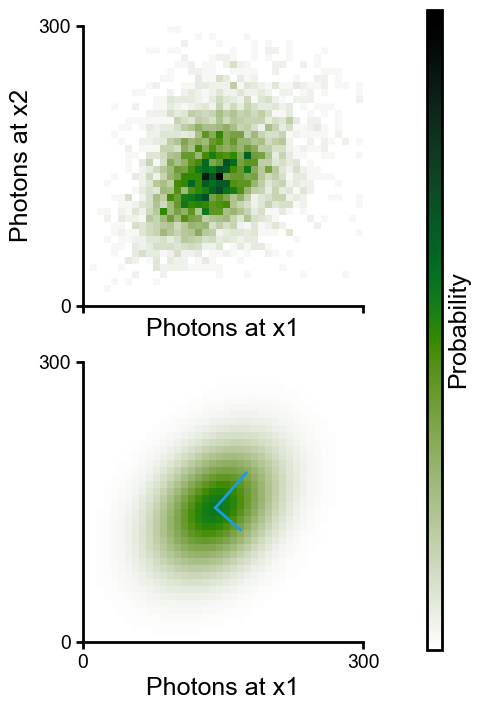

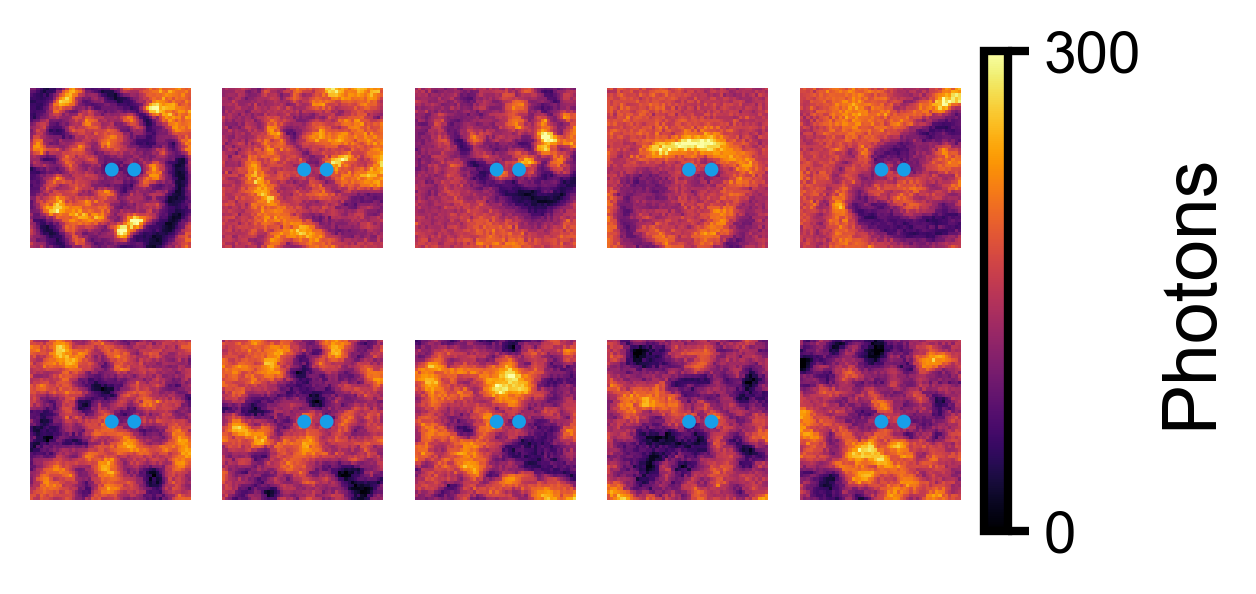

In [30]:
from scipy.stats import multivariate_normal
import cmasher as cmr
import cmocean as cm
from matplotlib.patches import Circle
from matplotlib.cm import ScalarMappable


display_image_indices = np.arange(11, 20)

patches_for_display = [extract_patches(images[index].reshape(1, *images.shape[1:]),
                                        patch_size, num_patches=1)[0] for index in display_image_indices]


x2_offset = (0, 7)
        

# x2_offset = (0, 13)

x1_position = (patches.shape[1] // 2, patches.shape[2] // 2)


display_lim = (0, 300)
# display_lim = (60, 230)

num_bins = 40
cmap = cmr.jungle.reversed()
color = get_color_cycle()[0]
bins = np.linspace(*display_lim, num_bins + 1)


x1_samples= patches[:, x1_position[0], x1_position[1]]
x2_samples = patches[:, x1_position[0] + x2_offset[0], x1_position[1] + x2_offset[1]]

# plot a a 2d historgram empirical distribution
p_x, yedges, xedges = np.histogram2d(x2_samples, x1_samples, bins=bins)
p_x /= p_x.sum()

design = np.stack([x1_samples, x2_samples], axis=1)
# compute mean and covariance
mean = np.mean(design, axis=0)
cov = np.cov(design.T)

gaussian_pdf = multivariate_normal.pdf(np.stack(
    np.meshgrid(np.linspace(*display_lim, num_bins), np.linspace(*display_lim, num_bins)), axis=-1),  mean=mean, cov=cov)
gaussian_pdf /= gaussian_pdf.sum()

# compute vmin and vmax for both plots
vmin = onp.min([p_x, gaussian_pdf])
vmax = onp.max([p_x, gaussian_pdf])

fig_dist, ax_dist = plt.subplots(2, 1, figsize=(5, 8 ), sharex=True, sharey=True)
# plot a a 2d historgram of the design matrix
ax_dist[0].imshow(p_x, cmap=cmap, origin='lower', extent=[display_lim[0], display_lim[1], display_lim[0], display_lim[1]], vmin=vmin, vmax=vmax)
clear_spines(ax_dist[0])
ax_dist[0].set(xticks=display_lim, yticks=display_lim, xlabel='Photons at x1', ylabel='Photons at x2')

# make another plot showing the PDF of the Gaussian
ax_dist[1].imshow(gaussian_pdf, 
    cmap=cmap, origin='lower', extent=[display_lim[0], display_lim[1], display_lim[0], display_lim[1]], vmin=vmin, vmax=vmax)
# draw the major and minor axes of the ellipse
eigvals, eigvecs = np.linalg.eigh(cov)
# plot them
for eigval, eigvec in zip(np.sqrt(eigvals), eigvecs.T):
    ax_dist[1].plot([mean[0], mean[0] +  eigval * eigvec[0]], [mean[1], mean[1] +  eigval * eigvec[1]], color=color, linewidth=2)
# same formatting as before
clear_spines(ax_dist[1])
ax_dist[1].set(xticks=display_lim, yticks=display_lim, xlabel='Photons at x1')

fig_img, ax_img = plt.subplots(2, num_images_to_show, figsize=(4, 2), dpi=300)
for i in range(num_images_to_show):
    image = patches_for_display[i]
    ax_img[0, i].imshow(image, cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
    ax_img[0, i].axis('off')
    ax_img[0, i].add_patch(Circle((x1_position[1], x1_position[0]), 1.5, color=color))
    ax_img[0, i].add_patch(Circle((x1_position[1] + x2_offset[1], x1_position[0] + x2_offset[0]), 1.5, color=color))

    ax_img[1, i].imshow(samples[i], cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
    ax_img[1, i].axis('off')
    ax_img[1, i].add_patch(Circle((x1_position[1], x1_position[0]), 1.5, color=color))
    ax_img[1, i].add_patch(Circle((x1_position[1] + x2_offset[1], x1_position[0] + x2_offset[0]), 1.5, color=color))


# add a colorbar
fig_img.subplots_adjust(right=0.9)
cbar_ax = fig_img.add_axes([0.92, 0.1, 0.02, 0.8])
sm = ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=display_lim[0], vmax=display_lim[1]))
fig_img.colorbar(sm, cax=cbar_ax)
# sparse ticks and label "Probability"
cbar_ax.set(yticks=display_lim,  ylabel='Photons')
fig_img.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'gaussian_approx_patches' + '.pdf', transparent=True, dpi=600)


# add a colorbar
fig_dist.subplots_adjust(right=0.9)
cbar_ax = fig_dist.add_axes([0.92, 0.1, 0.03, 0.8])
fig_dist.colorbar(ScalarMappable(cmap=cmap), cax=cbar_ax)
# sparse ticks and label "Probability"
cbar_ax.set(yticks=[],  ylabel='Probability')

# fig_dist.suptitle(f'{x2_offset}')

fig_dist.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'px_gaussian_approx_gaussian' + '.pdf', transparent=True, dpi=600)


# fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300)
# ax.imshow(images[display_image_indices[0]], cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
# ax.axis('off')
# fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'gaussian_approx_images' + '.pdf', transparent=True, dpi=600)

## show channel

In [12]:
num_noisy_images_for_histogram = 50000
single_patch = patches[1]
point_offset = (0, 7)
clean_intensity = (single_patch[single_patch.shape[0] // 2, single_patch.shape[1] // 2], 
                    single_patch[single_patch.shape[0] // 2 + point_offset[0] // 2, single_patch.shape[1] // 2 + point_offset[1] // 2])

intensity_samples_1 = []
intensity_samples_2 = []
noisy_patches = np.stack([add_noise(single_patch) for i in tqdm(range(num_noisy_images_for_histogram))], axis=0)
intensity_samples_1.append(noisy_patches[:, noisy_patches.shape[1] // 2, noisy_patches.shape[2] // 2].flatten())
intensity_samples_2.append(noisy_patches[:, noisy_patches.shape[1] // 2 + point_offset[0] // 2, 
                                        noisy_patches.shape[2] // 2 + point_offset[1] // 2].flatten())

100%|██████████| 50000/50000 [03:37<00:00, 230.32it/s]


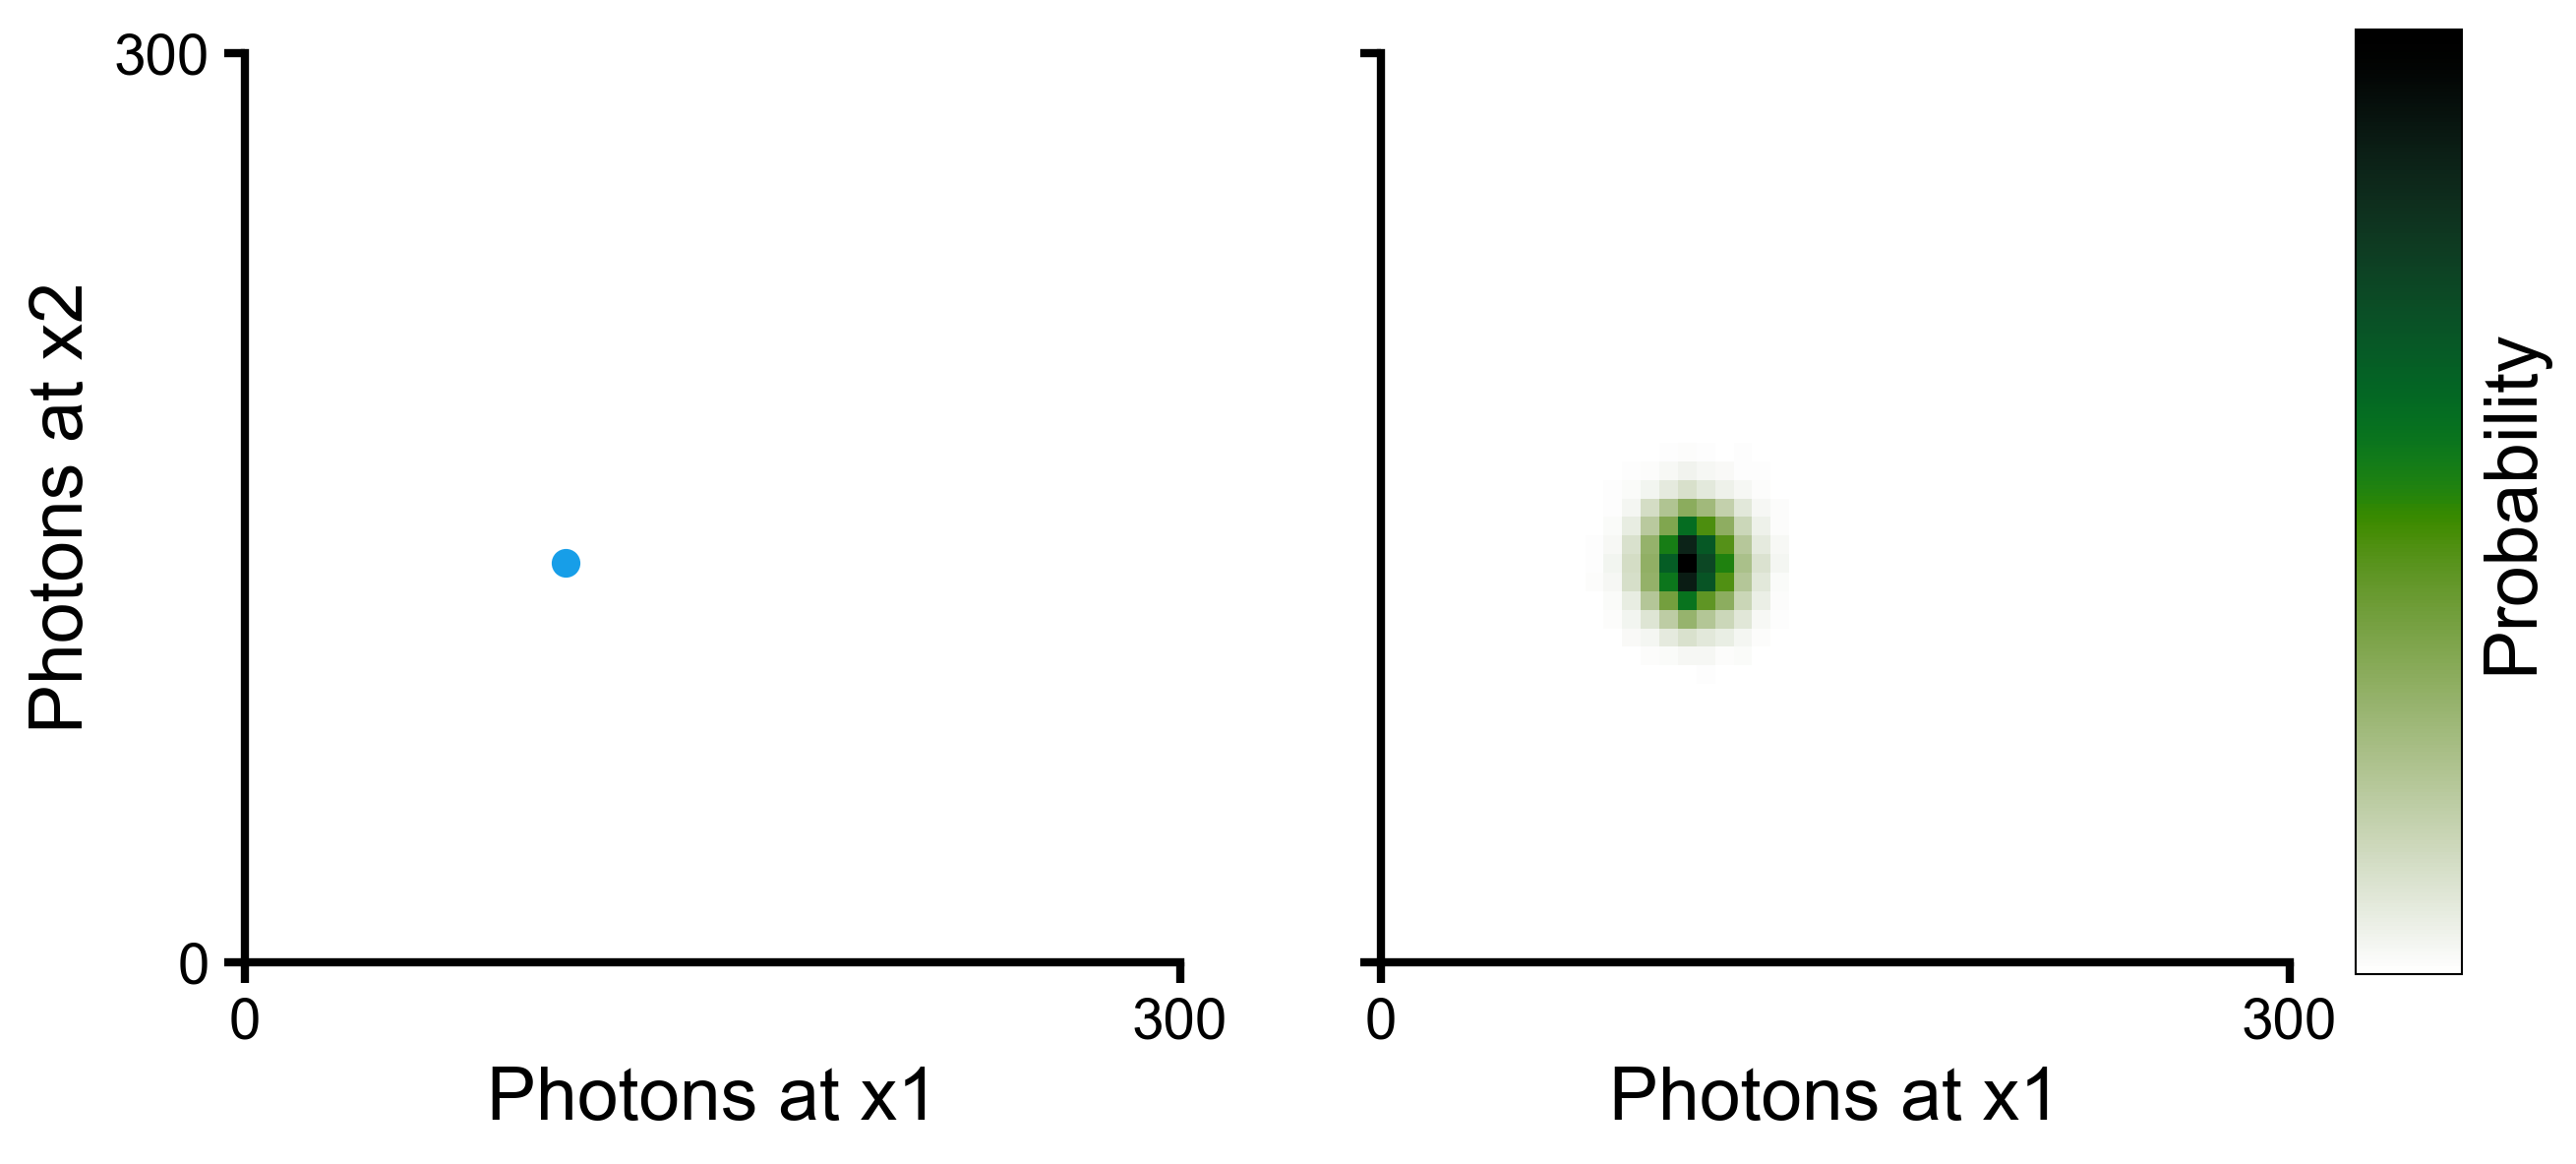

In [13]:
cmap = cmr.jungle.reversed()

fig, ax = plt.subplots(1, 2, figsize=(9, 4), dpi=300, sharex=True, sharey=True)

ax[0].plot(clean_intensity[0], clean_intensity[1], 'o', color=get_color_cycle()[0])
clear_spines(ax[0])
ax[0].set(xlabel='Photons at x1', ylabel='Photons at x2')

plot_intensity_coord_histogram(ax[1], intensity_samples_1, intensity_samples_2, display_lim[1], 
                                 bins=50, cmap=cmap)
ax[1].set(ylabel=None)

fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'conditional histogram' + '.pdf', transparent=True)

100%|██████████| 3/3 [00:00<00:00, 240.15it/s]


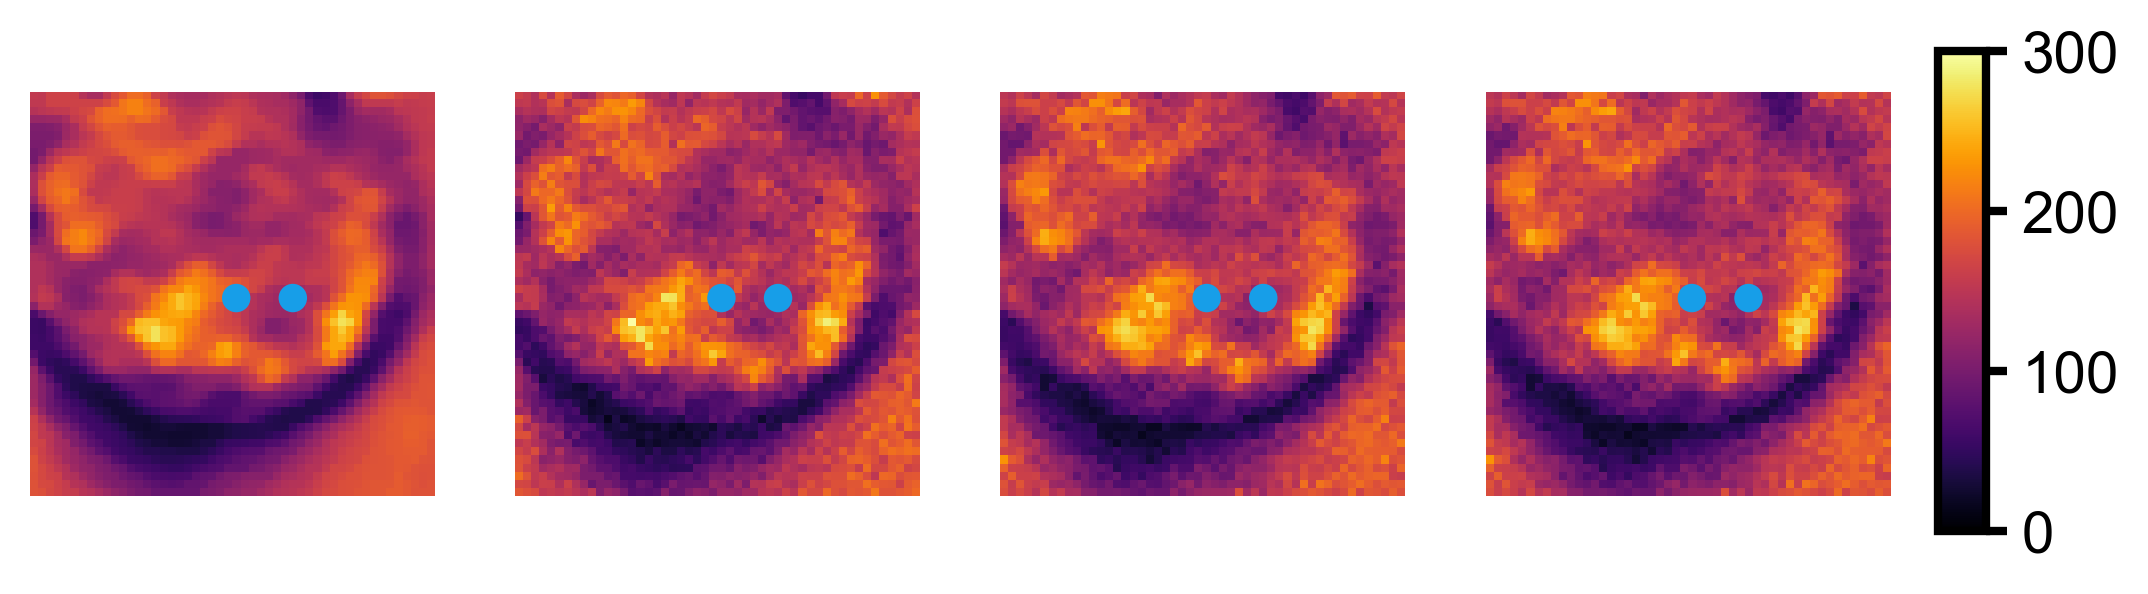

In [14]:
image = load_bsccm_images(bsccm, channel, indices=[27], convert_units_to_photons=True, edge_crop=edge_crop, median_filter=True)[0]
patch_to_use = extract_patches(image.reshape(1, *image.shape), patch_size, num_patches=1)[0]

images = load_bsccm_images(bsccm, channel, num_images=1000, convert_units_to_photons=True, edge_crop=edge_crop, median_filter=False)
patch_to_use *= photons_per_pixel / np.mean(images)
# make noisy_patches_for_display
noisy_patches = np.stack([add_noise(patch_to_use) for i in tqdm(range(num_images_to_show))], axis=0)


# plot the single patch and some noisy realizations of it
fig, ax = plt.subplots(1, 4, figsize=(8, 2), dpi=300)
ax[0].imshow(patch_to_use, cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
ax[0].axis('off')
ax[0].add_patch(Circle((patch_to_use.shape[1] // 2, patch_to_use.shape[0] // 2), 1.5, color=color))
ax[0].add_patch(Circle((patch_to_use.shape[1] // 2 + point_offset[1], patch_to_use.shape[0] // 2 + point_offset[0]), 1.5, color=color))

for i in range(1, 4):
    ax[i].imshow(noisy_patches[i], cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
    ax[i].axis('off')
    ax[i].add_patch(Circle((patch_to_use.shape[1] // 2, patch_to_use.shape[0] // 2), 1.5, color=color))
    ax[i].add_patch(Circle((patch_to_use.shape[1] // 2 + point_offset[1], patch_to_use.shape[0] // 2 + point_offset[0]), 1.5, color=color))

# add color scale bar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
sm = ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=display_lim[0], vmax=display_lim[1]))
fig.colorbar(sm, cax=cbar_ax)

# save
fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'noisy_patches' + '.pdf', transparent=True, dpi=600)